# Two transmon + bus cavity

## Undriven

In [57]:
%matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm, block_diag
from math import pi
from qutip import *
import sympy
import functools, operator

Using matplotlib backend: TkAgg


In [2]:
def hamiltonian_eff_H0(w1,w2,J,alpha1,alpha2,N):
    """ 
    Two-transmon effective Hamiltonian with zero excitation in bus. 
    Eq. 2.12, Magesan
    w1, w2:  angular freq
    """
    b1 = destroy(N)
    b2 = destroy(N)
    
    I = qeye(N)

    # Eq. 2.21, Magesan
    H1 = w1*tensor(b1.dag()*b1, I) + alpha1/2.0*tensor(b1.dag()*b1.dag()*b1*b1, I)
    H2 = w2*tensor(I, b2.dag()*b2) + alpha2/2.0*tensor(I, b2.dag()*b2.dag()*b2*b2)
    H12 = J*(tensor(b1.dag(), b2) + tensor(b1, b2.dag())) 
    
    H_eff = H1 + H2 + H12
    
    return H_eff

def hamiltonian_eff_Hd(wd, Omega_X, Omega_Y, t, N):
    """ 
    CR drive Hamiltonian. Eq.2.14.
    All arguments are single number, not an array
    wd: angular freq
    """
    b1 = destroy(N)  # qubit 2 is target qubit
#     Hd = (Omega_X * np.cos(wd*t) + Omega_Y * np.sin(wd*t)) * tensor(qeye(N),b2 + b2.dag())
    Hd = (Omega_X * np.cos(wd*t) + Omega_Y * np.sin(wd*t)) * tensor(b1 + b1.dag(),qeye(N))
    
    return Hd

def ZZ_computed(J, alpha1, alpha2, Delta):
    """ Eq.4.5 in Magesan"""
    return -J**2*(1/(Delta + alpha1) + 1/(-Delta + alpha2)) * 2

In [3]:
# parameters for IBM qubit
w1, w2 = 2*pi*5, 2*pi*5.2 # in GHz
J = 0.005*2*pi
alpha1, alpha2 = -0.35*2*pi, -0.35*2*pi # in GHz
N=5

H_eff = hamiltonian_eff_H0(w1,w2,J,alpha1,alpha2,N)
eigen = H_eff.eigenstates()
ZZ = eigen[0][5] - eigen[0][1] - eigen[0][2]  # in GHz

sympy.SparseMatrix(np.round((H_eff)[:, 0:13],2))
print(f'ZZ = {ZZ*1e3/(2*pi):.3f} (MHz)')
print(f'ZZ_by_formula = {ZZ_computed(J,alpha1,alpha2,w1-w2)*1e3/(2*pi):.3f} (MHz)')

ZZ = 0.423 (MHz)
ZZ_by_formula = 0.424 (MHz)


In [4]:
eigen[0]

array([  0.        ,  31.41514163,  32.67334851,  60.63216698,
        63.14392431,  64.09114939,  87.64991143,  91.4194034 ,
        93.30269448,  94.56601264, 112.46851434, 117.49482602,
       120.3217872 , 122.83078145, 123.78669517, 145.14018436,
       148.90897676, 150.79083124, 152.06261183, 175.61160088,
       178.11596075, 179.08655243, 203.87692006, 205.15844344,
       229.96458224])

## CR Driven: two-level qubit case

In [203]:
w1, w2 = 2*pi*5, 2*pi*5.2 # in GHz
J = 0.01*2*pi
alpha1, alpha2 = -0.35*2*pi, -0.35*2*pi
N =2
Omega_X, Omega_Y = 0.02*2*pi,0*2*pi

b1 = destroy(N)
b2 = destroy(N)

HA = w2*(tensor(b1.dag()*b1, qeye(N)) + tensor(qeye(N), b2.dag()*b2))
R = lambda t: (-1j*HA*t).expm()

H0 = hamiltonian_eff_H0(w1,w2,J,alpha1,alpha2,N)
Hd = lambda t:hamiltonian_eff_Hd(w2, Omega_X, Omega_Y, t, N)

HR = lambda t: R(t).dag() * (H0 + Hd(t)) * R(t) - HA

In [204]:
t_list = np.linspace(0, 2, 401)  # in ns
HR_list = [HR(t) for t in t_list]
H_R = functools.reduce(operator.add, HR_list) / len(HR_list)

In [205]:
H_R.conj().trans()
H_R

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.        +0.j          0.        +0.j          0.06248237-0.00025391j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.06283185+0.j
   0.06248237-0.00025391j]
 [ 0.06248237+0.00025391j  0.06283185+0.j         -1.25663706+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.06248237+0.00025391j  0.        +0.j
  -1.25663706+0.j        ]]

In [17]:
avg_list = []
for N in range(2,401):
    temp = (functools.reduce(operator.add,[HR_list[i] for i in range(N)]) / N)
    temp = np.real(temp[2,0])
    avg_list.append(temp)
    
plt.plot(avg_list)
# avg_list

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]]

## Least action

In [206]:
eigen = H_R.eigenstates()
# np.linalg.norm(eigen[1][3])

In [207]:
eigen[1][0]

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.04191927+0.j        ]
 [ 0.06799578+0.00027632j]
 [-0.84850975-0.00344813j]
 [-0.52308748-0.00425146j]]

In [209]:
# find X
X_array = np.column_stack( (eigen[1][0],eigen[1][1],eigen[1][2],eigen[1][3]))
X = Qobj(X_array)

# find X_BD and XP
A, B = X[0:2,0:2], X[2:4, 2:4]
X_BD_array = block_diag(A,B)
X_BD = Qobj(X_BD_array)
XP = X_BD * X_BD.conj().trans()

# find T
T = X * X_BD.conj().trans() * XP.sqrtm().inv()

# find H_R_BD
T.dims = H_R.dims
H_R_BD =  T.conj().trans() * H_R * T
H_R_BD

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-1.2597286 +0.00000000e+00j -0.00310116+1.26023328e-05j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [-0.00310116-1.26023328e-05j -1.26284711+0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.00621004+0.00000000e+00j  0.00310116-1.26023328e-05j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.00310116+1.26023328e-05j  0.00309153+0.00000000e+00j]]

In [210]:
w1, w2 = 2*pi*5, 2*pi*5.2 # in GHz
J = 0.01*2*pi
alpha1, alpha2 = -0.35*2*pi, -0.35*2*pi
N =2
Omega_X, Omega_Y = 0.02*2*pi,0*2*pi

Delta=w1-w2
print(J * Omega_X /np.sqrt(Delta**2+ Omega_X**2)/2)
print( (Delta-np.sqrt(Delta**2+ Omega_X**2))/2)

0.0031260015268123323
-1.2597708391340494


## CR Driven: three-level case

In [86]:
# get block-diagonal full H_RWA Hamiltonina, then take computational subspace
# to fine Pauli coefficients: ZX,ZZ,ZI,IX,and IZ

# Main question: how to compute H_RWA. How can we ignore other than e^{-iwt} or e^{iwt}.

In [192]:
w1, w2 = 2*pi*5.2, 2*pi*5 # in GHz
J = 0.01*2*pi
alpha1, alpha2 = -0.35*2*pi, -0.35*2*pi
Omega_X, Omega_Y = 20*2*pi,20*2*pi
N =3

b1 = destroy(N)
b2 = destroy(N)

H0 = hamiltonian_eff_H0(w1,w2,J,alpha1,alpha2,N)

In [193]:
# digonalize H0: remove J
eigen = H0.eigenstates()
eigen[1].size

# find U
U_array = np.column_stack( [eigen[1][i] for i in range(eigen[1].size)])
U = Qobj(U_array)
U.dims = H0.dims

# digonalize H0
H0_D = U.conj().trans() * H0 * U
sympy.Matrix(H0_D)

# get new Hd and HR
wd = (eigen[0][5]-eigen[0][2]+eigen[0][1])/2
Hd = lambda t:hamiltonian_eff_Hd(wd, Omega_X, Omega_Y, t, N)
Hd_D = lambda t: U.conj().trans() * Hd(t) * U

# To rotating frame
HA = wd*(tensor(b1.dag()*b1, qeye(N)) + tensor(qeye(N), b2.dag()*b2))
R = lambda t: (-1j*HA*t).expm()
HR = lambda t: R(t).dag() * (H0_D + Hd_D(t)) * R(t) - HA

In [194]:
(eigen[0][5]-eigen[0][2]+eigen[0][1])/2
# eigen[0]

31.418074040177185

In [195]:
# average over 10 period
t_list = np.linspace(0, 2, 401)  # in ns
HR_list = [HR(t) for t in t_list]
H_R = functools.reduce(operator.add,HR_list) / len(HR_list)

In [196]:
HR_list[0]+HR_list[1]
H_R

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j -3.13793833e+00+3.12190493e+00j
  -3.22138515e-01+1.45703351e-03j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-3.13793833e+00-3.12190493e+00j -5.28128198e-03+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  8.30506439e-03+0.00000000e+00j
   1.02539063e+01-1.02015137e+01j  3.18534313e-01-1.44073170e-03j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-3.22138515e-01-1.45703351e-03j  0.00000000e+00+0.00000000e+00j
  -3.01604507e+01+0.00000000e+00j  1.27716875e-04+1.27064301e-04j
   4.52224368e-01+0.00000000e+00j -1.13805883e+01+1.13224388e+01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00

In [197]:
avg_list = []
for N in range(2,401):
    temp = (functools.reduce(operator.add,[HR_list[i] for i in range(N)]) / N)
    temp = np.real(temp[0,1])
    avg_list.append(temp)
    

In [93]:
# plt.plot(avg_list)
f=np.fft.fft(avg_list)
plt.plot(np.absolute(f))
plt.yscale('log')

In [198]:
# least action
eigen = H_R.eigenstates()

# find X
X_array = np.column_stack( [eigen[1][i] for i in range(eigen[1].size)])
X = Qobj(X_array)

# find X_BD and XP
A, B, C = X[0:2,0:2], X[2:4, 2:4], X[4:10, 4:10]
X_BD_array = block_diag(A,B,C)
X_BD = Qobj(X_BD_array)
# X_BD = X_BD.tidyup(atol=1e-3)
XP = X_BD * X_BD.conj().trans()

# find T
T = X * X_BD.conj().trans() * XP.sqrtm().inv()

# find H_R_BD
T.dims = H_R.dims
H_R_BD =  T.conj().trans() * H_R * T
H_R_BD

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[-5.03086658e+01+0.j         -8.44459791e-01+7.75840776j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [-8.44459791e-01-7.75840776j -5.55097174e+01+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
  -1.38350872e+01+0.j          7.66132116e-01+0.36148883j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   7.66132116e-01-0.36148883j -2.06532810e+01+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00

In [199]:
H_R_BD.tidyup(atol=1.5e-4)


Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[-5.03086658e+01+0.j         -8.44459791e-01+7.75840776j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [-8.44459791e-01-7.75840776j -5.55097174e+01+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
  -1.38350872e+01+0.j          7.66132116e-01+0.36148883j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   7.66132116e-01-0.36148883j -2.06532810e+01+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00

In [200]:
def from16to8(M):
    return np.array([M[0,0],M[1,0],M[0,1],M[1,1],M[2,2],M[3,2],M[2,3],M[3,3]]).reshape(8,1)

# Get Pauli coeff.
II = tensor(qeye(2), qeye(2))
IX = tensor(qeye(2), sigmax())
IY = tensor(qeye(2), sigmay())
IZ = tensor(qeye(2), sigmaz())
ZI = tensor(sigmaz(), qeye(2))
ZY = tensor(sigmaz(), sigmay())
ZX = tensor(sigmaz(), sigmax())
ZZ = tensor(sigmaz(), sigmaz())

a = np.column_stack([from16to8(II),from16to8(IX),from16to8(IY),from16to8(IZ)
                    ,from16to8(ZI),from16to8(ZX),from16to8(ZY),from16to8(ZZ)])

b = from16to8(H_R_BD[0:4, 0:4])

c = np.linalg.solve(a, b)

In [201]:
sympy.Matrix(a)
sympy.Matrix(c)

Matrix([
[                          -35.0766878283766],
[                        -0.0391638374208262],
[  -4.0599482951568 - 8.32667268468867e-16*I],
[                           3.00481132566825],
[                          -17.8325037409416],
[-0.805295953814262 + 8.88178419700125e-16*I],
[ -3.69845946305381 - 1.16573417585641e-15*I],
[                         -0.404285539610635]])

In [202]:
test=Qobj(IX.data.reshape(16,1))
IX.data.reshape(16,1).todense()

matrix([[0.+0.j],
        [1.+0.j],
        [0.+0.j],
        [0.+0.j],
        [1.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [1.+0.j],
        [0.+0.j],
        [0.+0.j],
        [1.+0.j],
        [0.+0.j]])

In [184]:
N =3

b1 = destroy(N)
b2 = destroy(N)
(tensor(b1.dag()*b1, qeye(N)) + tensor(qeye(N), b2.dag()*b2))

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 4.]]

# Effective g calculation

In [48]:
%matplotlib 
import matplotlib.pyplot as plt
import numpy as np

Using matplotlib backend: TkAgg


In [49]:
# import numpy as np

def compute_g_eff(wc, w1, w2, C1, C2, C12, C1c, C2c, Cc):
    """
    w in GHz and C in fF
    """
    eta = C1c*C2c/C12/Cc
    Sigma = 2 / (1/(w1+wc) + 1/(w2+wc))
    Delta = 2/(1/(w1-wc) + 1/(w2-wc))

    g = 1/2*(wc*eta/2/Delta - wc*eta/2/Sigma + eta + 1)* C12/np.sqrt(C1*C2)*np.sqrt(w1*w2)
    
    return g

def compute_g1(wc,w1,C1,C1c,Cc):
    """
    Qubit-coupler coupling strengh in GHz.
    C in fF
    """
    g1 = 1/2*C1c/np.sqrt(C1*Cc)*np.sqrt(w1*wc)
    
    return g1

def compute_g2(wc,w2,C2,C2c,Cc):
    """
    Qubit-coupler coupling strengh in GHz.
    C in fF
    """
    g2 = 1/2*C2c/np.sqrt(C2*Cc)*np.sqrt(w2*wc)
    
    return g2

def compute_g12(w1,w2,C1,C2,C12,C1c,C2c,Cc):
    """
    Qubit-qubit coupling strengh in GHz.
    C in fF
    """
    eta = C1c*C2c/C12/Cc
    g12 = 1/2*(1 + eta)*C12/np.sqrt(C1*C2)*np.sqrt(w1*w2)
    
    return g12


## (g_eff, g1, g12) vs coupler freq.

In [46]:
# parameters from Yan's paper
# w1, w2 = 4, 4 # in GHz
# (C1, C2, C12, C1c, C2c, Cc) = (70,72,0.1,4,4.2,200)

# parameters for IBM qubit
w1, w2 = 5, 5 # in GHz
(C1, C2, C12, C1c, C2c, Cc) = (60,62,0.1,2,2.2,50)
# (C1, C2, C12, C1c, C2c, Cc) = (60,60,0.10,10,14,100)

wc_list = np.linspace(5.5, 8, 101)
geff = compute_g_eff(wc_list,w1,w2,C1, C2,C12,C1c,C2c,Cc)
g1 = compute_g1(wc_list,w1,C1,C1c,Cc)
g12 = compute_g12(w1,w2,C1,C2,C12,C1c,C2c,Cc)

fig,(ax,ax1) = plt.subplots(2,1, figsize=(10,8))
ax.plot(wc_list, geff*1e3)
ax.set_ylabel(r'$g_{eff}$ (MHz)', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid('on')

ax1.plot(wc_list, g1*1e3)
ax1.set_xlabel('Coupler Frequency (GHz)', fontsize=18)
ax1.set_ylabel(r'$g_{12}$ (MHz)', fontsize=18)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax1.grid('on')

print(f'g12 = {compute_g12(w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3:.3f} MHz')

g12 = 7.706 MHz


# Transmon with a Duffing model

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import sympy

In [54]:
# parameters for IBM qubit
w1 = 5 # in GHz
alpha1 = -0.35 # in GHz

N = 3
b1 = destroy(N)

H = w1*b1.dag()*b1 + alpha1/2.0*b1.dag()*b1.dag()*(b1*b1-qeye(N))

In [55]:
# show H in matrix form
sympy.SparseMatrix(np.round((H)[:, 0:13],2))

Matrix([
[   0,   0,    0],
[   0, 5.0,    0],
[0.25,   0, 9.65]])

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


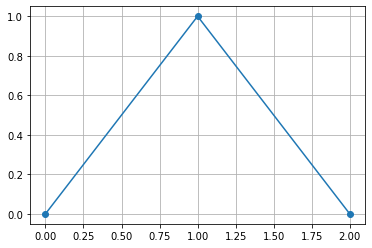

In [56]:
eigen = H.eigenstates()

# for i in range(eigen[1].size):
#     plt.plot(eigen[1][i],'o-') 
plt.plot(eigen[1][1],'o-') 
plt.grid()


/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(<Figure size 576x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffb04cc3970>)

/usr/lib/python3/dist-packages/matplotlib/ticker.py:785: ComplexWarning: Casting complex values to real discards the imaginary part
  loc_range_oom = int(math.floor(math.log10(loc_range)))
/usr/lib/python3/dist-packages/matplotlib/ticker.py:590: ComplexWarning: Casting complex values to real discards the imaginary part
  s = self.format % xp
/usr/lib/python3/dist-packages/matplotlib/text.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/usr/lib/python3/dist-packages/matplotlib/text.py:676: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(textobj.convert_yunits(textobj._y))


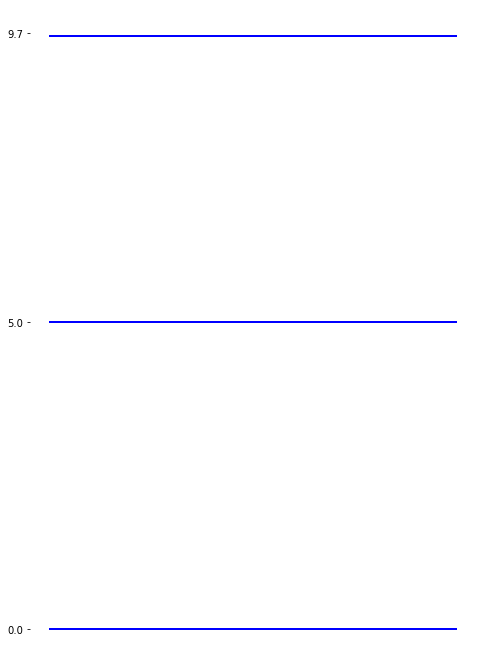

In [57]:
plot_energy_levels([H], show_ylabels=True)

# ZZ by effective two-qubit Hamiltonian
Ref: Yan et al., PRApplied 2018

In [58]:
%matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qutip import *
import sympy

Using matplotlib backend: TkAgg


In [59]:
def hamiltonian_eff_two_qubit(w1,w2,wc,C1,C2,C12,C1c,C2c,Cc,alpha1,alpha2,N):
    """
    Effective Two-qubit Hamiltonian, coupler decoupled.
    """
    b1 = destroy(N)
    b2 = destroy(N)

    w1_dr = w1 + compute_g1(wc,w1,C1,C1c,Cc)**2 * (1/(w1-wc)-1/(w1+wc))
    w2_dr = w2 + compute_g2(wc,w2,C1,C1c,Cc)**2 * (1/(w2-wc)-1/(w2+wc))
    geff = compute_g_eff(wc, w1, w2, C1, C2, C12, C1c, C2c, Cc)

    # Eq. B2
    H_eff = ( w1_dr*tensor(b1.dag()*b1,qeye(N)) + alpha1/2.0*tensor(b1.dag()*b1.dag()*b1*b1, qeye(N))
        + w2_dr*tensor(qeye(N),b2.dag()*b2) + alpha2/2.0*tensor(qeye(N), b2.dag()*b2.dag()*b2*b2)
        + geff * (tensor(b1.dag(),b2) + tensor(b1, b2.dag())))

    return H_eff

In [64]:
# parameters for IBM qubit
w1, w2 = 5, 5.2 # in GHz
wc = 6
(C1, C2, C12, C1c, C2c, Cc) = (70,72,0.1,4,4.2,200)

alpha1 = -0.35 # in GHz
alpha2 = -0.35

N = 3

# compute Hamiltonian
H_eff1 = hamiltonian_eff_two_qubit(w1,w2,wc,C1,C2,C12,C1c,C2c,Cc,alpha1,alpha2,N)
eigen1 = H_eff1.eigenstates()

sympy.SparseMatrix(np.round((H_eff1)[:, 0:13],2))
print(f'g1={compute_g1(wc,w1,C1,C1c,Cc)*1e3:.1f} MHz')
print(f'g12={compute_g12(w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3:.3f} MHz')
print(f'geff={compute_g_eff(wc,w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3:.3f} MHz')

# Compute eigenvalues and find $\zeta = \omega_{11}-\omega_{01}-\omega_{10}$
ZZ = eigen1[0][5] - eigen1[0][1] - eigen1[0][2]  # in GHz
print(f'ZZ = {ZZ*1e3:.2f} (MHz)')

g1=92.6 MHz
g12=6.608 MHz
geff=-4.389 MHz
ZZ = 0.32 (MHz)


In [65]:
# compute eigenvalues and eigenstates.
eigen1 = H_eff1.eigenstates()  # eigen is a tuble with two elements. eigen[0] = eigenvalues, eigen[1]=eigenstates.
eigen1[1][5].full()

array([[ 0.        +0.j],
       [ 0.        +0.j],
       [-0.04055287+0.j],
       [ 0.        +0.j],
       [ 0.99911326+0.j],
       [ 0.        +0.j],
       [-0.0113211 +0.j],
       [ 0.        +0.j],
       [ 0.        +0.j]])

## (ZZ, g_eff) vs Coupler Frequency

In [66]:
# Note: This diagonal effective Hamiltonian doesn't seem to give right ZZ. This is
# probabaly because a perturbative approach,i.e.,SW transformation, is not enough.
# So, the only full Hamiltonian with g coupling terms would work to give right ZZ.
# However, for driven ZZ calculation, it may be ok to use the digonal effective 
# two-quibt Hamiltonian. I want to know the sign and magnitude of 
# driven ZZ vs CR ampliutude. 
# If I can do this with two-transmon + bus cavity case, then I could do the same thing 
# tunable coupler case since the effective two-qubit Hamiltonian for coupler case has
# the same form as bus cavity case. The only difference is J vs g_eff. If I assume, 
# ZZ goes roughly by J**2, then driven ZZ would just increase...?

# parameters for IBM qubit
w1, w2 = 5, 5.2 # in GHz
wc = 5.5
(C1, C2, C12, C1c, C2c, Cc) = (60,60,0.1,2,2, 50)
alpha1 = -0.35 # in GHz
alpha2 = -0.35

# w1, w2 = 4.961, 4.926 # in GHz
# wc = 5.5
# (C1, C2, C12, C1c, C2c, Cc) = (70,72,0.13,2.4,2.4,100)
# alpha1 = -0.206 # in GHz
# alpha2 = -0.202

N = 3

# sweep
wc_list = np.linspace(5.5,7.5,31)
ZZ_list, g_eff_list, g1_list, g2_list, g12_list = [], [], [], [], []
ev_list = []

for wc in wc_list:
    H_eff = hamiltonian_eff_two_qubit(w1,w2,wc,C1,C2,C12,C1c,C2c,Cc,alpha1,alpha2,N)
    eigen = H_eff.eigenstates()
    ev_list.append(eigen[1][5])
    ZZ = (eigen[0][5] - eigen[0][1] - eigen[0][2])*1e3  # in MHz
    
    ZZ_list.append(ZZ)
    g_eff_list.append(compute_g_eff(wc,w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3)
    g1_list.append(compute_g1(wc,w1,C1,C1c,Cc)*1e3)
    g2_list.append(compute_g2(wc,w2,C1,C1c,Cc)*1e3)
    g12_list.append(compute_g12(w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3)
    
   
# plot
fig,(ax,ax1, ax2) = plt.subplots(3,1, figsize=(10,10))
ax.plot(wc_list, ZZ_list,'-o')
# ax.set_xlabel('Coupler Frequency (GHz)', fontsize=18)
ax.set_ylabel(r'$\zeta$ (MHz)', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid('on')

ax1.plot(wc_list, g_eff_list,'-o')
ax1.plot(wc_list, g12_list,'-o')
ax1.set_ylabel(r'$g_{eff}, g_{12}$ (MHz)', fontsize=18)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax1.grid('on')

ax2.plot(wc_list, g1_list,'-o')
ax2.plot(wc_list, g2_list,'-o')
ax2.set_xlabel('Coupler Frequency (GHz)', fontsize=18)
ax2.set_ylabel(r'$g_1, g_2$ (MHz)', fontsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.grid('on')

In [144]:
max_arg = []
for ev in ev_list:
    max_arg.append(np.argmax(np.absolute(ev.full())))

In [186]:
max_arg

[6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

In [156]:
eigen[1][5].full()

array([[0.        +0.j],
       [0.        +0.j],
       [0.09995332+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.99487785+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.01507939+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j]])

# two transmons + Coupler

In [67]:
%matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qutip import *
import sympy

Using matplotlib backend: TkAgg


In [80]:
def hamiltonian_eff_2Q_coupler(w1,w2,wc,C1,C2,C12,C1c,C2c,Cc,alpha1,alpha2,alphac,N):
    """
    Full Hamiltonian of two transmons and a coupler.
    Note: counter-rotating terms are ignored. This produces negative ZZ as experimentally shown in Li paper.
    """
    g1 = compute_g1(wc,w1,C1,C1c,Cc)
    g2 = compute_g2(wc,w2,C1,C1c,Cc)
    g12 = compute_g12(w1,w2,C1,C2,C12,C1c,C2c,Cc)

    b1 = destroy(N)
    b2 = destroy(N)
    bc = destroy(N)
    I1 = qeye(N)
    I2 = qeye(N)
    Ic = qeye(N)

    # Eq. A17
    H1 = w1*tensor(b1.dag()*b1, I2, Ic) + alpha1/2.0*tensor(b1.dag()*b1.dag()*b1*b1, I2, Ic)
    H2 = w2*tensor(I1, b2.dag()*b2, Ic) + alpha2/2.0*tensor(I1, b2.dag()*b2.dag()*b2*b2, Ic)
    Hc = wc*tensor(I1, I2, bc.dag()*bc) + alphac/2.0*tensor(I1, I2, bc.dag()*bc.dag()*bc*bc)
    H1c = g1*(tensor(b1.dag(), I2, bc) + tensor(b1, I2, bc.dag())) #- tensor(b1.dag(), I2, bc.dag()) -tensor(b1, I2, bc))
    H2c = g2*(tensor(I1, b2.dag(), bc) + tensor(I1, b2, bc.dag())) #- tensor(I1, b2.dag(), bc.dag()) -tensor(I1, b2, bc))
    H12 = g12*(tensor(b1.dag(), b2, Ic) + tensor(b1, b2.dag(), Ic)) # - tensor(b1.dag(), b2.dag(), Ic) -tensor(b1, b2, Ic))
    
    H_eff = H1 + H2 + Hc + H1c + H2c + H12
    
    return H_eff



In [81]:
# parameters for IBM qubit
w1, w2, wc = 5, 5, 6 # in GHz
(C1, C2, C12, C1c, C2c, Cc) = (70,72,0.1,4,4.2,150)
alpha1, alpha2, alphac = -0.35, -0.35, -0.35# in GHz
N=3

H_eff2 = hamiltonian_eff_2Q_coupler(w1,w2,wc,C1,C2,C12,C1c,C2c,Cc,alpha1,alpha2,alphac,N)
eigen2 = H_eff2.eigenstates()
ZZ = eigen2[0][6] - eigen2[0][1] - eigen2[0][2]  # in GHz

sympy.SparseMatrix(np.round((H_eff2)[:, 0:13],2))
print(f'g1={compute_g1(wc,w1,C1,C1c,Cc)*1e3:.1f} MHz')
print(f'g12={compute_g12(w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3:.3f} MHz')
print(f'geff={compute_g_eff(wc,w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3:.3f} MHz')
print(f'ZZ = {ZZ*1e3:.5f} (MHz)')

g1=106.9 MHz
g12=7.466 MHz
geff=-5.442 MHz
ZZ = -0.09965 (MHz)


In [82]:
# show H_eff2 matrix
sympy.SparseMatrix(np.round((H_eff2)[:, 0:13],2))

Matrix([
[0,    0,     0,    0,    0,     0,    0,     0,    0,    0,    0,     0,    0],
[0,  6.0,     0, 0.11,    0,     0,    0,     0,    0, 0.11,    0,     0,    0],
[0,    0, 11.65,    0, 0.15,     0,    0,     0,    0,    0, 0.15,     0,    0],
[0, 0.11,     0,  5.0,    0,     0,    0,     0,    0, 0.01,    0,     0,    0],
[0,    0,  0.15,    0, 11.0,     0, 0.15,     0,    0,    0, 0.01,     0, 0.11],
[0,    0,     0,    0,    0, 16.65,    0,  0.21,    0,    0,    0,  0.01,    0],
[0,    0,     0,    0, 0.15,     0, 9.65,     0,    0,    0,    0,     0, 0.01],
[0,    0,     0,    0,    0,  0.21,    0, 15.65,    0,    0,    0,     0,    0],
[0,    0,     0,    0,    0,     0,    0,     0, 21.3,    0,    0,     0,    0],
[0, 0.11,     0, 0.01,    0,     0,    0,     0,    0,  5.0,    0,     0,    0],
[0,    0,  0.15,    0, 0.01,     0,    0,     0,    0,    0, 11.0,     0, 0.11],
[0,    0,     0,    0,    0,  0.01,    0,     0,    0,    0,    0, 16.65,    0],
[0,    0,     0,   

In [83]:
# plot_energy_levels([H_eff2], N=7, show_ylabels=True)

## (ZZ, g) vs Coupler frequency

In [84]:
# parameters for IBM qubit
w1, w2 = 5, 5.05 # in GHz
wc = 5.5
(C1, C2, C12, C1c, C2c, Cc) = (60,60,0.1, 2,2, 50)
alpha1 = -0.35 # in GHz
alpha2 = -0.35
alphac = -0.40

N = 3

# sweep
wc_list = np.linspace(5.5,7.5,31)
# wc_list = np.linspace(3.5,4.5,31)
ZZ_list, g_eff_list, g1_list, g2_list, g12_list = [], [], [], [], []
ev_list = []

for wc in wc_list:
    H_eff = hamiltonian_eff_2Q_coupler(w1,w2,wc,C1,C2,C12,C1c,C2c,Cc,alpha1,alpha2,alphac,N)
    eigen = H_eff.eigenstates()
    ev_list.append(eigen[1][6])
    ZZ = (eigen[0][6] - eigen[0][1] - eigen[0][2])*1e3  # in MHz
    
    ZZ_list.append(ZZ)
    g_eff_list.append(compute_g_eff(wc,w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3)
    g1_list.append(compute_g1(wc,w1,C1,C1c,Cc)*1e3)
    g2_list.append(compute_g2(wc,w2,C1,C1c,Cc)*1e3)
    g12_list.append(compute_g12(w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3)
    
   
# plot
fig,(ax,ax1, ax2) = plt.subplots(3,1, figsize=(10,10))
ax.plot(wc_list, ZZ_list,'-o')
# ax.set_xlabel('Coupler Frequency (GHz)', fontsize=18)
ax.set_ylabel(r'$\zeta$ (MHz)', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid('on')

ax1.plot(wc_list, g_eff_list,'-o')
ax1.plot(wc_list, g12_list,'-o')
ax1.set_ylabel(r'$g_{eff}, g_{12}$ (MHz)', fontsize=18)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax1.grid('on')

ax2.plot(wc_list, g1_list,'-o')
ax2.plot(wc_list, g2_list,'-o')
ax2.set_xlabel('Coupler Frequency (GHz)', fontsize=18)
ax2.set_ylabel(r'$g_1, g_2$ (MHz)', fontsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.grid('on')

In [85]:
# np.argmax(np.absolute(eigen[1][9].full()))

In [241]:
max_arg = []
for ev in ev_list:
    max_arg.append(np.argmax(np.absolute(ev.full())))
max_arg

[30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30]

# Compare eff. Hamil. vs diag. eff. Hamil.

In [17]:
# parameters for IBM qubit
w1, w2 = 5, 5 # in GHz
wc = 5.5
(C1, C2, C12, C1c, C2c, Cc) = (70,72,0.1,4,4.2,150)
alpha1 = -0.35 # in GHz
alpha2 = -0.35
alphac = -0.4

N = 5
eigen1 = hamiltonian_eff_two_qubit(w1,w2,wc,C1,C2,C12,C1c,C2c,Cc,alpha1,alpha2,N).eigenstates()
eigen2 = hamiltonian_eff_2Q_coupler(w1,w2,wc,C1,C2,C12,C1c,C2c,Cc,alpha1,alpha2,alphac,N).eigenstates()

plt.figure()
plt.plot(eigen1[0],'-o', label='Effective two-transmons Hamil.')
plt.plot(eigen2[0],'-o', label='Two-qubit+ coupler Hamil.')
plt.legend()
plt.grid()

In [258]:
from scipy.constants import e,h

In [265]:
e**2/2/60*1e15/h/1e6

322.83715541098536

# Xuexin's Hamiltonian

In [46]:
aaa = np.zeros((10,10))
aaa[2,0]=1
aaa[3,1]=1
aaa[5,2]=np.sqrt(2)
aaa[8,3]=np.sqrt(2)
aaa[7,4]=1
aaa[9,5]=np.sqrt(3)
aaa_Q = Qobj(aaa)
aaa_Q*aaa_Q.dag()

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]]

# Procedure to find Pauli-coefficients with CR
1. Build effective two-qubit Hamiltonian.
2. Diagonalize the two-qbuti Hamiltonian to get rid of coupling by either SW or numerical diagonalization. Dressed state.
3. Build driving Hamiltonian in the dressed state.
4. Move into rotating frame.
5. Block-diagonalize the total Hamiltonian by SW or least action.
6. Find Pauli-coefficients.

## Define qubit frequencies and J

In [22]:
wm = 5164       # CSFQ w01
del_m0 = 600   # first anharmonicity
del_m1 = 430  # second anharmon.
gdm = 80

wr = 6292

wt = 5292   # transmon
del_t0 = -329.1
del_t1 = -369.7
gdt = -80

gmt = 0  # csfq-transmon direct g

# CSFQ, j=0,1,2
w1_d = lambda j: wm*j + del_m0/2*j*(j-1) if j<3 else wm*j + del_m0/2*j*(j-1) + del_m1-del_m0 # dressed freq
gamma1 = lambda j: j/(wr + w1_d(j-1) - w1_d(j))
w1_b = lambda j: w1_d(j) - gamma1(j) * gdm**2  # bare freq. j=1,2,3

# transmon, j=0,1,2
w2_d = lambda j: wt*j + del_t0/2*j*(j-1) if j<3 else wt*j + del_t0/2*j*(j-1) + del_t1-del_t0 # dressed freq
gamma2 = lambda j: j/(wr + w2_d(j-1) - w2_d(j))
w2_b = lambda j: w2_d(j) - gamma2(j) * gdt**2  # bare freq.

# J, {j1,j2}=0,1,2
J = lambda j1,j2 : gmt - gdm*gdt/2*(1/(wr+w1_d(j1)-w1_d(j1+1)) + 1/(wr+w2_d(j2)-w2_d(j2+1)) 
                                    + 1/(wr-w1_d(j1)+w1_d(j1+1)) + 1/(wr-w2_d(j2)+w2_d(j2+1))) 

In [20]:
J(0,0)

6.592452135485313

## Build effective two-qubit Hamiltonian

In [191]:
# states to consider
# 00, 01,10,11,02,20,03,12,21,30
diag = np.array([0, w2_b(1), w1_b(1), w1_b(1)+w2_b(1), w2_b(2), w1_b(2), w2_b(3)
                 ,w1_b(1)+w2_b(2), w1_b(2)+w2_b(1), w1_b(3)])
H0 = Qobj(np.diag(diag))

b1dag = np.zeros((10,10))
b1dag[2,0] = 1
b1dag[3,1] = 1
b1dag[5,2] = np.sqrt(2)
b1dag[8,3] = np.sqrt(2)
b1dag[7,4] = 1
b1dag[9,5] = np.sqrt(3)
b1dag = Qobj(b1dag)

b2dag = np.zeros((10,10))
b2dag[1,0] = 1
b2dag[3,2] = 1
b2dag[4,1] = np.sqrt(2)
b2dag[7,3] = np.sqrt(2)
b2dag[6,4] = np.sqrt(3)
b2dag[8,5] = 1
b2dag = Qobj(b2dag)

V0  = np.zeros((10,10))
V0[2,1] = J(0,0)
V0[1,2] = J(0,0)
V0[4,3] = np.sqrt(2)*J(0,1)
V0[5,3] = np.sqrt(2)*J(1,0)
V0[3,4] = np.sqrt(2)*J(0,1)
V0[3,5] = np.sqrt(2)*J(1,0)
V0[7,6] = np.sqrt(3)*J(0,2)
V0[6,7] = np.sqrt(3)*J(0,2)
V0[8,7] = np.sqrt(4)*J(1,1)
V0[7,8] = np.sqrt(4)*J(1,1)
V0[9,8] = np.sqrt(3)*J(2,0)
V0[8,9] = np.sqrt(3)*J(2,0)
V0 = Qobj(V0)

b1 = b1dag.dag()
b2 = b2dag.dag()

b1t = b1 + b1dag
b2t = b2 + b2dag
ntot = b1dag*b1 + b2dag*b2

In [192]:
b1dag*b1

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]]

In [193]:
H0

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[    0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.        ]
 [    0.          5285.6            0.             0.
      0.             0.             0.             0.
      0.             0.        ]
 [    0.             0.          5158.32624113     0.
      0.             0.             0.             0.
      0.             0.        ]
 [    0.             0.             0.         10443.92624113
      0.             0.             0.             0.
      0.             0.        ]
 [    0.             0.             0.             0.
  10245.26942292     0.             0.             0.
      0.             0.        ]
 [    0.             0.             0.             0.
      0.         10903.75757576     0.             0.
      0.             0.        ]
 [    0.             0.             0.             0

In [194]:
V0

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          6.59245214  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          6.59245214  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          8.21399833 13.8625133
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          8.21399833  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         13.8625133   0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          9.1692497   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   9.1692497  

## Diagonalize two-qubit Hamiltonian

In [249]:
# By solving eigenvalue
H1 = H0 + V0
eigen = Ht.eigenstates()

# find U
U = sorted_diag_op(eigen)
U.dims = H1.dims

# digonalize H0
H2 = U.dag() * H1 * U

In [247]:
U

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.98668329e-01 -5.15903950e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.15903950e-02  9.98668329e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.98692815e-01
   4.13024295e-02 -3.01126357e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.13098659e-02
  -9.99146313e-01 -3.75387721e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.01024333e-02
  -8

In [248]:
sympy.Matrix(np.round(H2,2))

Matrix([
[0,       0,       0,        0,        0,        0,        0,        0,        0,        0],
[0, 5285.94,       0,        0,        0,        0,        0,        0,        0,        0],
[0,       0, 5157.99,        0,        0,        0,        0,        0,        0,        0],
[0,       0,       0, 10443.85,        0,        0,        0,        0,        0,        0],
[0,       0,       0,        0, 10244.93,        0,        0,        0,        0,        0],
[0,       0,       0,        0,        0, 10904.18,        0,        0,        0,        0],
[0,       0,       0,        0,        0,        0, 14836.65,        0,        0,        0],
[0,       0,       0,        0,        0,        0,        0, 15403.33,        0,        0],
[0,       0,       0,        0,        0,        0,        0,        0, 16184.42,        0],
[0,       0,       0,        0,        0,        0,        0,        0,        0, 16931.44]])

## Driving Hamiltonian in dressed state

In [207]:
# get new Hd and HR
Omega = 1 # MHz
wd = (H2[3,3]-H2[2,2]+H2[1,1])/2  # 10443 - 5157 + 5285 in MHz
Hd = lambda t: Omega * np.cos(2*pi*wd*t)* b1t
Hd_D = lambda t: U.dag() * Hd(t) * U

# To rotating frame
R = lambda t: (-1j*2*pi*wd*ntot*t).expm()
HR = lambda t: R(t).dag() * (H2 + Hd_D(t)) * R(t) - ntot *wd

# average over 10 period
t_list = np.linspace(0, 2, 401)*1e-3  # in us
HR_list = [HR(t) for t in t_list]
H_R = functools.reduce(operator.add, HR_list) / len(HR_list)
H_R

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  2.59978919e-02-9.82006788e-05j
   5.03257850e-01-1.90093345e-03j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 2.59978919e-02+9.82006788e-05j  3.90391377e-02+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  5.01493236e-01-1.89426805e-03j
   2.07538198e-02-7.83924789e-05j -5.19043159e-02+1.96055860e-04j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 5.03257850e-01+1.90093345e-03j  0.00000000e+00+0.00000000e+00j
  -1.27915841e+02+0.00000000e+00j -4.73882334e-02+1.78997463e-04j
  -1.69229258e-03+6.39222138e-06j -7.10608408e-01+2.68414948e-03j
   0.00000000e+00+0.00000000e+00j  0.00000000

In [208]:
# aaa= [HR(t)[3,1] for t in t_list] 
# plt.plot(t_list, aaa)
H2+Hd(0)
ntot

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]]

In [209]:
avg_list = []
for N in range(2,401):
    temp = (functools.reduce(operator.add,[HR_list[i] for i in range(N)]) / N)
    temp = np.real(temp[0,1])
    avg_list.append(temp)
    

In [210]:
 plt.plot(avg_list)
    
# f=np.fft.fft(avg_list)
# plt.plot(np.absolute(f))
# plt.yscale('log')

In [132]:
from sympy import I
Omega = 10
wd = sympy.Symbol('wd')
t = sympy.Symbol('t')

Hd = Omega * (sympy.exp(-I*wd*t) + sympy.exp(I*wd*t))/2 * sympy.Matrix(b1t.data.toarray())
Hdt = (U.dag()).data.toarray() * Hd * U.data.toarray()

Htot = H2.data.toarray() + Hdt

Ur = sympy.exp(-I*wd *sympy.Matrix(ntot.data.toarray())*t)
Urdag = sympy.exp(I*wd *sympy.Matrix(ntot.data.toarray())*t)
H3t = Urdag * Htot * Ur -  sympy.Matrix(ntot.data.toarray())

H3t_RWA = sympy.simplify(H3t).subs(sympy.exp(-2*I*wd*t),0)

In [133]:
sympy.simplify(H3t).subs([(sympy.exp(2*I*wd*t),0), (sympy.oo,0)])


Matrix([
[                0,                 zoo,                zoo,                  0,                    0,                    0,                0,                0,                0,                0],
[ 4.99334164448514,    5156.98568041008,                  0,                zoo,                  zoo,                  zoo,                0,                0,                0,                0],
[0.257951975085346,                   0,   5284.94056072468,                zoo,                  zoo,                  zoo,                0,                0,                0,                0],
[                0, -0.0167909850402803,  0.205920111856128,    10242.929874963,                    0,                    0,              zoo,              zoo,              zoo,              zoo],
[                0,  -0.470187676635091,   4.97583307954979,                  0,     10441.8481628593,                    0,              zoo,              zoo,              zoo,              zoo],
[

## Least action

In [243]:
# least action
eigen = H_R.eigenstates()

# find X
X = sorted_diag_op(eigen)

# find X_BD and XP
A, B, C = X[0:2,0:2], X[2:4, 2:4], X[4:10, 4:10]
X_BD_array = block_diag(A,B,C)
X_BD = Qobj(X_BD_array)
# X_BD = X_BD.tidyup(atol=1e-3)
XP = X_BD * X_BD.conj().trans()

# find T
T = X * X_BD.dag() * XP.sqrtm().inv()

# find H_R_BD
T.dims = H_R.dims
H_R_BD =  T.dag() * H_R * T
H_R_BD.tidyup(1e-7)

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.97993647e-03+0.00000000e+00j  2.59963234e-02-9.81947541e-05j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 2.59963234e-02+9.81947541e-05j  4.09972254e-02+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.27918918e+02+0.00000000e+00j -4.73867614e-02+1.78991902e-04j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e

## Pauli coefficient

In [245]:
def from16to8(M):
    return np.array([M[0,0],M[1,0],M[0,1],M[1,1],M[2,2],M[3,2],M[2,3],M[3,3]]).reshape(8,1)

# Get Pauli coeff.
II = tensor(qeye(2), qeye(2))
IX = tensor(qeye(2), sigmax())
IY = tensor(qeye(2), sigmay())
IZ = tensor(qeye(2), sigmaz())
ZI = tensor(sigmaz(), qeye(2))
ZY = tensor(sigmaz(), sigmay())
ZX = tensor(sigmaz(), sigmax())
ZZ = tensor(sigmaz(), sigmaz())

a = np.column_stack([from16to8(II),from16to8(IX)/2,from16to8(IY)/2,from16to8(IZ)/2
                    ,from16to8(ZI)/2,from16to8(ZX)/2,from16to8(ZY)/2,from16to8(ZZ)/2])

b = from16to8(H_R_BD[0:4, 0:4])

c = np.linalg.solve(a, b)
sympy.Matrix(np.round(c,6))

Matrix([
[-63.958475],
[  -0.02139],
[   -8.1e-5],
[    1.2e-5],
[127.959928],
[  0.073383],
[  0.000277],
[  -0.03903]])

# Helper

In [262]:
from collections import OrderedDict
import itertools

def list_energies(f1,alpha1, beta1, f2, alpha2, beta2, sort=False):
    """
    Calculate energy levels. E00 = 0
    """
    numStates = 4 # 0,1,2,3 states
    state1 = [0, f1, f1+f1+alpha1,f1+f1+f1+alpha1+beta1]
    state2 = [0, f2, f2+f2+alpha2,f2+f2+f2+alpha2+beta2]
    
    result_dict = {}
    for prod in itertools.product(range(numStates), range(numStates)):
        temp = {prod:state1[prod[0]] + state2[prod[1]]}
        result_dict.update(temp)
    
    if sort:
        sorted_dict = OrderedDict(sorted(result_dict.items(), key=lambda x: x[1]))
        return sorted_dict
    else:
        return result_dict
    
list_energies(5.05, 0.6, 0.5, 5.25,-0.33, -0.37,sort=True)    
# list_energies(5.25,-0.33, -0.37, 5.05, -0.3, -0.33, sort=True)    

OrderedDict([((0, 0), 0),
             ((1, 0), 5.05),
             ((0, 1), 5.25),
             ((0, 2), 10.17),
             ((1, 1), 10.3),
             ((2, 0), 10.7),
             ((0, 3), 15.05),
             ((1, 2), 15.219999999999999),
             ((2, 1), 15.95),
             ((3, 0), 16.25),
             ((1, 3), 20.1),
             ((2, 2), 20.869999999999997),
             ((3, 1), 21.5),
             ((2, 3), 25.75),
             ((3, 2), 26.42),
             ((3, 3), 31.3)])

In [242]:
def sorted_diag_op(eigen):
    """
    Diagonalizing matrix by the order of eigenvector
    
    Args:
        eigen : output of eigenstates() method in qutip
       
    Return: a new diagonalizing operator Qobj
    """
       
    index_list = [np.argmax(np.absolute(vec)) for vec in eigen[1]]
    
    X_array = np.column_stack([eigen[1][index_list.index(i)] for i in range(eigen[1].size)])
    X = Qobj(X_array)
    
    return X